<a href="https://colab.research.google.com/github/shainedl/Papers-Colab/blob/master/Variational_Principal_Components.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Based on *Variational Principal Components* (Bishop '99)

In [0]:
import numpy as np
import scipy.special as sp
from scipy.stats import multivariate_normal 
from scipy.stats import gamma 
import matplotlib.pyplot as plt

In [0]:
class BayesianPCA():
  
  def __init__(self, a_alpha=10e-3, b_alpha=10e-3, a_tau=10e-3, b_tau=10e-3, beta=10e-3):
    
    # hyperparameters
    self.a_alpha = a_alpha
    self.b_alpha = b_alpha
    self.a_tau = a_tau
    self.b_tau = b_tau
    self.beta = beta 
     
  def __reestimate(self):
    """
    Cycle through the groups of variables in turn to re-estimate each distribution 
    """
    
    # observation parameter
    self.tau = self.a_tau_tilde / self.b_tau_tilde

    # latent variables
    self.sigma_x = np.linalg.inv(np.identity(self.q) + self.tau *
                   (np.trace(self.sigma_w) + np.dot(self.mean_w.T, self.mean_w)))
    self.mean_x = self.tau * np.dot(np.dot(self.sigma_x, self.mean_w.T),(self.t_n - self.mean_mu))
    
    # observation parameter                                
    self.sigma_mu = np.identity(self.d) / (self.beta + self.N * self.tau)
    w_x = np.dot(self.mean_w, self.mean_x)
    sum = 0
    for n in range(self.N):
      sum += np.subtract(self.t_n[:,n], w_x[:,n])
    self.mean_mu = (self.tau * np.dot(self.sigma_mu, sum)).reshape(-1,1)
    
    # hyperparameter controlling the columns of W
    self.alpha = self.a_alpha_tilde / self.b_alpha_tilde
                                     
    # weight                                 
    self.sigma_w = np.linalg.inv(np.diag(self.alpha) + self.tau * 
                   (self.N * self.sigma_x + np.dot(self.mean_x, self.mean_x.T)))
    self.mean_w = (self.tau * np.dot(self.mean_x, (np.subtract(self.t_n.T, self.mean_mu.T)))).T
    
    # alpha's gamma distribution parameter                            
    self.b_alpha_tilde = self.b_alpha + 0.5 * (np.trace(self.sigma_w) + np.diag(np.dot(self.mean_w.T, self.mean_w)))                                                     
    # tau's gamma distribution parameter     
    self.b_tau_tilde = np.asarray([self.b_tau + 0.5 * np.sum(np.dot(self.t_n.T, self.t_n))  + \
                       0.5 * self.N * (np.trace(self.sigma_mu) + np.dot(self.mean_mu.flatten(), self.mean_mu.flatten())) + \
                       0.5 * np.trace(np.dot(np.trace(self.sigma_w) + \
                       np.dot(self.mean_w.T, self.mean_w), self.N * self.sigma_x + \
                       np.dot(self.mean_x, self.mean_x.T))) + \
                       np.sum(np.dot(np.dot(self.mean_mu.T, self.mean_w), self.mean_x)) - \
                       np.sum(np.dot(np.dot(self.t_n.T, self.mean_w), self.mean_x)) - \
                       np.sum(np.dot(self.t_n.T, self.mean_mu))])       
    
  def __get_elbo(self):
    """
    Computes the rigorous lower bound on the true log marginal likelihood 
    
    Returns
    -------
      float
        the lower bound = prior + likelihood - entropy 
    
    """                             
    # random sample
    x = np.asarray([np.random.multivariate_normal(self.mean_x[:,n], self.sigma_x) for n in range(self.N)]).T
    mu = np.random.multivariate_normal(self.mean_mu.flatten(), self.sigma_mu)
    w = np.asarray([np.random.multivariate_normal(self.mean_w[i], self.sigma_w) for i in range(self.d)])
    alpha = np.random.gamma(self.a_alpha_tilde, 1 / self.b_alpha_tilde)     
    tau = np.random.gamma(self.a_tau_tilde, 1 / self.b_tau_tilde)                             
                
      
    # priors
    # p(x) = N(x|0,I_q)
    prior = np.sum(np.asarray([multivariate_normal.logpdf(x[:,i], np.zeros(self.q), np.identity(self.q)) for i in range(self.N)]))
      
    # p(w|alpha) = conditional distribution                   
    prior += np.sum(np.asarray([(self.d / 2) * np.log(alpha[i] / (2 * np.pi)) - 0.5 * alpha[i] * np.sum(np.power(w[:,i],2)) for i in range(self.q)]))                
                                 
    # p(alpha) = Gamma(a, b)                             
    prior += np.sum(gamma.logpdf(alpha, self.a_alpha, scale=1/self.b_alpha))                            
                                 
    # p(mu) = N(mu|0,Beta^-1I)       
    prior += multivariate_normal.logpdf(mu, np.zeros(self.d), np.identity(self.d)/self.beta)
                    
    # p(tau) = Gamma(c, d)      
    prior += np.sum(gamma.logpdf(tau, self.a_tau, scale=1/self.b_tau))
        
                    
    # log likelihood of the conditional distribution 
    # p(t_n | x_n, W, mu, tau)
    w_x = np.dot(w, x)
    list_t = []
    for n in range(self.N):
      list_t.append(w_x[:,n] + mu)
    likelihood = np.sum(np.asarray([multivariate_normal.logpdf(self.t_n[:,n], np.asarray(list_t).T[:,n], np.identity(self.d) / tau) for n in range(self.N)]))                 
           
      
    # entropy
    # q(x) 
    entropy = self.N * (0.5 * np.log(np.linalg.det(self.sigma_x) + (self.d / 2) * (1 + np.log(2 * np.pi))))   
                       
    # q(mu)
    entropy += 0.5 * np.log(np.linalg.det(self.sigma_mu) + (self.d / 2) * (1 + np.log(2 * np.pi)))
                            
    # q(W)          
    entropy += self.d * (0.5 * np.log(np.linalg.det(self.sigma_w) + (self.d / 2) * (1 + np.log(2 * np.pi))))  
                         
    # q(alpha)
    entropy += self.q * (np.log(sp.gamma(self.a_alpha_tilde)) - (self.a_alpha_tilde - 1) \
                        * sp.digamma(self.a_alpha_tilde) + self.a_alpha_tilde)
    for i in range(self.q):
      entropy -= np.log(self.b_alpha_tilde[i])
                         
    # q(tau)   
    entropy += - (self.a_tau_tilde - 1) * sp.digamma(self.a_tau_tilde) - \
               np.log(self.b_tau_tilde) + self.a_tau_tilde  
    # will ignore np.log(sp.gamma(self.a_tau_tilde)) since = inf
    
    return prior + likelihood - entropy   
                         
  def fit(self, t_n, iterations = 1000, threshold = 1.0):
    """
    Fits the data
    
    Parameters 
    ----------
    t_n : d x N matrix
      observed data to be fit
      
    iterations: int
      number of iterations to re-estimate the lower bound
    
    threshold: float
      determines convergence
      
    """
    self.t_n = t_n
    self.d = self.t_n.shape[0]                     
    self.q = self.d - 1
    self.N = self.t_n.shape[1]   
    
    # variational parameters
    self.mean_x = np.random.randn(self.q, self.N)
    self.sigma_x = np.identity(self.q)
    self.mean_mu = np.random.randn(self.d, 1)
    self.sigma_mu = np.identity(self.d)
    self.mean_w = np.random.randn(self.d, self.q)
    self.sigma_w = np.identity(self.q)
    self.a_alpha_tilde = self.a_alpha + self.d / 2
    self.b_alpha_tilde = np.abs(np.random.randn(self.q))  
    self.a_tau_tilde = self.a_tau + self.N * self.d / 2
    self.b_tau_tilde = np.abs(np.random.randn(1))
                     
    self.elbos = [self.__get_elbo()]  
    for i in range(iterations):
      self.__reestimate()
      self.elbos.append(self.__get_elbo())
      if np.abs(self.elbos[-2] - self.elbos[-1]) <= threshold:
        print('ELBO converged.')
        print("Iterations: ", i+1)                   
        print("ELBO: ", int(self.elbos[-1])) 
        break
              
      if (i+1) % 100 == 0:
        print("Iterations: ", i+1)                   
        print("ELBO: ", int(self.elbos[-1])) 
        
        if i == iterations:
          print('Ended without convergence.')
   

In [0]:
def hinton(matrix, max_weight=None, ax=None):
    """
    Draw Hinton diagram for visualizing a weight matrix.
    From https://matplotlib.org/3.1.1/gallery/specialty_plots/hinton_demo.html
    
    """
    ax = ax if ax is not None else plt.gca()

    if not max_weight:
        max_weight = 2 ** np.ceil(np.log(np.abs(matrix).max()) / np.log(2))

    ax.patch.set_facecolor('gray')
    ax.set_aspect('equal', 'box')
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

    for (x, y), w in np.ndenumerate(matrix):
        color = 'white' if w > 0 else 'black'
        size = np.sqrt(np.abs(w) / max_weight)
        rect = plt.Rectangle([x - size / 2, y - size / 2], size, size,
                             facecolor=color, edgecolor=color)
        ax.add_patch(rect)

    ax.autoscale_view()
    ax.invert_yaxis()

Iterations:  100
ELBO:  -1537
Iterations:  200
ELBO:  -1263
Iterations:  300
ELBO:  -912
Iterations:  400
ELBO:  -1537
Iterations:  500
ELBO:  -973
Iterations:  600
ELBO:  -1153
Iterations:  700
ELBO:  -1019
Iterations:  800
ELBO:  -1795
Iterations:  900
ELBO:  -2370
Iterations:  1000
ELBO:  -968


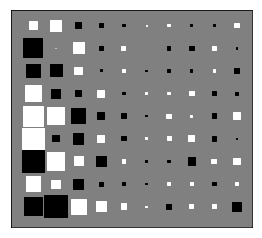

In [16]:
"""
We generate 100 data points in d = 10 dimensions from a Gaussian distribution 
having standard deviations of (5, 4, 3, 2) along four orthogonal directions 
and a standard deviation of 1 in the remaining five directions
"""
X = np.random.multivariate_normal(np.zeros(10), np.diag([5,4,3,2,1,1,1,1,1,1]), 100).T

"""
Hinton diagram of <W> from variational Bayesian PCA 
"""
test = BayesianPCA()
test.fit(X) 
hinton(test.mean_w)

Other helpful links:

https://en.wikipedia.org/wiki/Variance
 - For expection of $X^{T}X$ or $||X||^2$
 
https://www.cs.princeton.edu/courses/archive/fall11/cos597C/lectures/variational-inference-i.pdf

https://www.programcreek.com/python/example/57185/numpy.random.multivariate_normal
- For generating random samples